### Regional Performance & Velocity
GeoPandas mapping of delivery performnace by state & regional levels.

In [1]:
import pandas as pd
import h3

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_customer_seller, add_brazil_geometry, plot_performance, read_state_name_lookup

In [2]:
df = read_customer_seller()
df['delivery_hours'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng,delivery_hours
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454,202.477778
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727,330.768889
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976,225.461111
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299,317.010000
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979,68.973056


#### Average Delivery Days per State

In [3]:
gp = df.groupby('cus_state')['delivery_hours'].mean().reset_index()
gp.head()

,cus_state,delivery_hours
0,AC,504.857111
1,AL,588.292235
2,AM,634.223782
3,AP,652.441625
4,BA,462.721424


In [4]:
gp = add_brazil_geometry(gp, 'cus_state')
gp.head()

,UF,geometry,delivery_hours,center
0,AC,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",504.857111,POINT (-70.44565 -9.33281)
1,AL,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",588.292235,POINT (-36.61065 -9.50338)
2,AP,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",652.441625,POINT (-51.9383 1.44925)
3,AM,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",634.223782,POINT (-64.66208 -4.2071)
4,BA,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",462.721424,POINT (-41.66166 -12.49308)


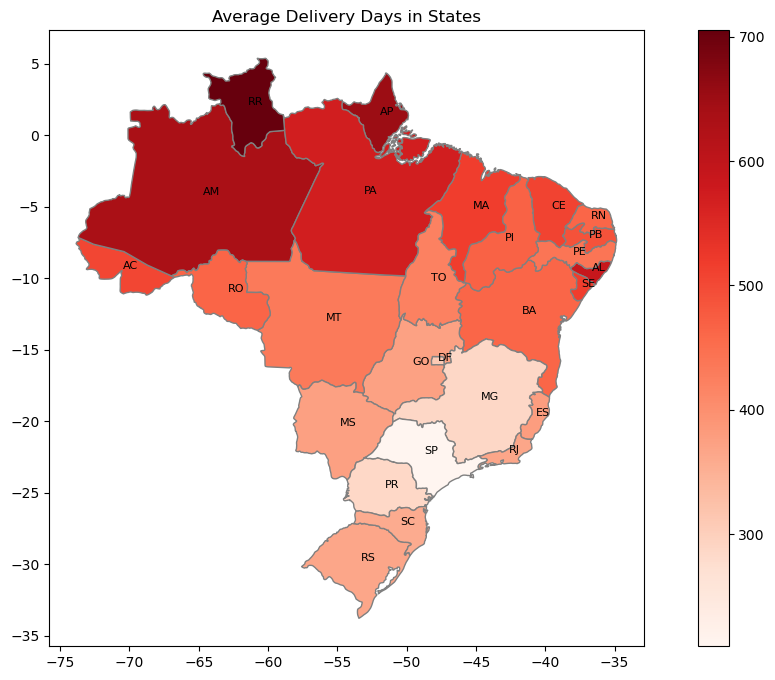

In [5]:
plot_performance(gp, 'delivery_hours', 'Average Delivery Days in States', cmap = "Reds")

#### Box Plot to Check the Stabality of Delivery System

Regardless of the states, there are a lot of long tails deliveries.\
Almost all states experience the maximum delay of 166+ days. Which is extremely bad.

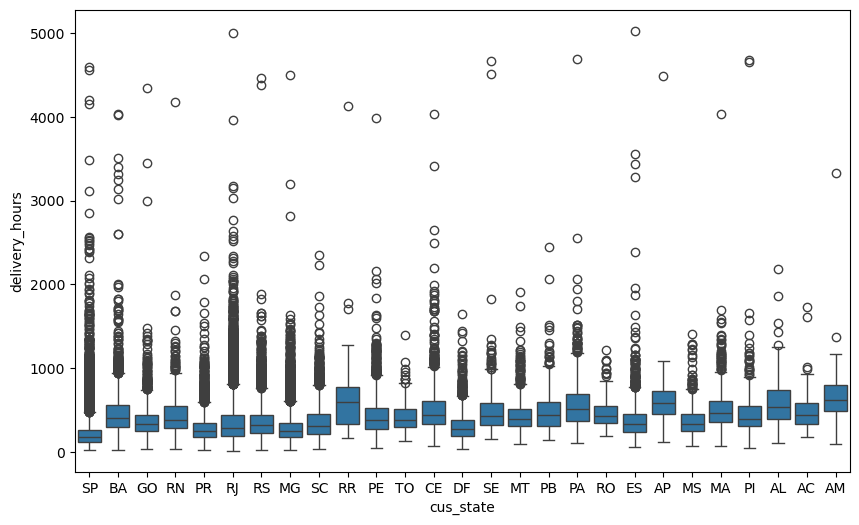

In [6]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(x="cus_state", y="delivery_hours", data=df, ax = ax)
plt.show()

#### Mean Delivery Time vs Velocity
Instead of 27 states, we will use Region for better understanding.\
The comparison with raw delivery time is not enough to determine the actual performance.\
The new performance matrix Velocity (Distance-km / Delivery Time-hours) is introduced.

**Finding**

* Regional analysis proves that `Mean Delivery Time` is a misleading metric.
* The regions closer to South-East have the best mean delivery time, but the lowest velocity.
* The North has the hightest velocity. Despite long durations, the North is highly efficient over distance.

##### Encode to Find Performance Region Wide

In [7]:
regions = read_state_name_lookup()
regions.head()

,0,1,2,3,4,5,6,7,8,9
0,BR,Brazil\n(entire country),Brasília,-,"8,514,204\n(slightly larger than\nthe Continen...","192,000,000(2008\nestimate)",82.5/17.5,"5,564","R$8,300",72.24
1,Common\nTwo Letter\nAbbreviation,State,Capitol\nCity,Region,Size\n(in km²),Population\n(2007 estimate),%\nPop.\nUrban/Rural,Number\nof Municipal Districts,Per\nCapita GNP in Reais (R$),Life\nExpectancy\n(2007 projection)
2,AC,Acre,Rio Branco,North,"152,581","664,000",69.6/30.4,24,"R$5,413",71.1
3,AL,Alagoas,Maceió,Northeast,"27,767","3,557,000",67.4/32.6,102,"R$3,876",65.4
4,AP,Amapá,Macapá,North,"142,814","619,000",93.7/6.3,16,"R$6,796",70.1


In [8]:
df = pd.merge(df, regions[["0", "3"]], left_on = "cus_state", right_on = "0", how="left")
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng,delivery_hours,0,3
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454,202.477778,SP,Southeast
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727,330.768889,BA,Northeast
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976,225.461111,GO,Center\nWest
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299,317.010000,RN,Northeast
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979,68.973056,SP,Southeast


##### Mean Delivery Time

In [9]:
gp = df.groupby("3")["delivery_hours"].mean().reset_index()
gp['days'] = gp['delivery_hours'] / 24
gp = gp.sort_values(by="delivery_hours")
gp.head()

,3,delivery_hours,days
4,Southeast,257.252848,10.718869
3,South,336.033696,14.001404
0,Center\nWest,359.508125,14.979505
2,Northeast,479.081196,19.961717
1,North,541.426335,22.559431


##### Distance-Normalized Performance (Efficiency Score)


In [10]:
df['dist'] = df.apply(lambda row: h3.great_circle_distance((row['cus_lat'], row['cus_lng']), (row['seller_lat'], row['seller_lng'])), axis=1)
df['velocity'] = df['dist'] / df['delivery_hours']

In [11]:
gp = df.groupby("3")["velocity"].mean().reset_index()
gp = gp.sort_values(by="velocity", ascending=False)
gp.head()

,3,velocity
1,North,5.160205
2,Northeast,4.641585
0,Center\nWest,3.046895
3,South,2.333016
4,Southeast,1.625049


#### Correlation between Total Orders & Velocity

There is a strong negative correlation between velociyt and total_orders.\
The carrier are having difficulities with handling large number of orders.

In [12]:
gp = df.groupby("cus_state").agg(
        velocity=("velocity", "mean"),
        total_orders=("order_id", "nunique")
    ).reset_index()
gp.head()

,cus_state,velocity,total_orders
0,AC,6.237003,80
1,AL,3.782054,397
2,AM,5.558287,145
3,AP,5.050723,67
4,BA,3.633235,3252


In [13]:
gp[['velocity', 'total_orders']].corr()

,velocity,total_orders
velocity,1.000000,-0.559785
total_orders,-0.559785,1.000000


#### Finding Area of Foucs (which state need detail analysis)

SP, and RJ. 
They have the largest total orders and slowest velocity.

In [14]:
gp.sort_values(by="velocity").head()

,cus_state,velocity,total_orders
25,SP,1.340665,40448
18,RJ,1.792393,12331
23,SC,1.931180,3536
17,PR,2.030966,4912
10,MG,2.279754,11332


In [15]:
gp.sort_values(by="total_orders", ascending=False).head()

,cus_state,velocity,total_orders
25,SP,1.340665,40448
18,RJ,1.792393,12331
10,MG,2.279754,11332
22,RS,2.874992,5328
17,PR,2.030966,4912
